In [145]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [146]:
data = pd.read_csv("/Users/marchen/Desktop/programming/AI/Sixth week/file/diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Outcome의 클래스 개수 = data['Outcome'].value_counts()의 개수가 2개라 explode도 길이를 2개로 만듬

<Axes: ylabel='count'>

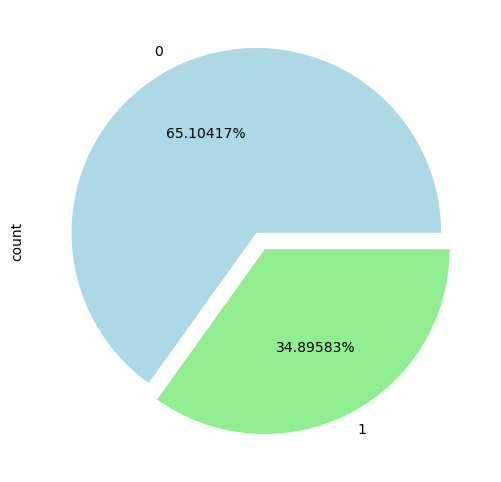

In [147]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05))

In [148]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [149]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [150]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,86,22,28,0,123,350,29,1
1,1,23,19,22,0,62,196,10,0
2,8,121,17,0,0,30,368,11,1
3,1,27,19,16,62,77,53,0,0
4,0,75,4,28,102,209,514,12,1
...,...,...,...,...,...,...,...,...,...
763,10,39,25,41,108,118,55,42,0
764,2,60,21,20,0,155,187,6,0
765,5,59,22,16,71,58,115,9,0
766,1,64,14,0,0,95,195,26,1


In [179]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [180]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [181]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [182]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # (batch_size,) → (batch_size, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1) # 뒤에 나오는 outputs.shape와 labels.shape의 크기를 맞추기 위해 view(-1, 1)을 한 것

In [183]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [184]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [185]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64) # 입력 크기를 8로 변경 - X의 feature 개수가 8개이기 때문
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # 이진 분류이므로 출력 뉴런 1개로 변경
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # 이진 분류이므로 sigmoid - 그러나 nn.BCEWithLogitsLoss()가 내부적으로 sigmoid를 포함하기에 삭제
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

In [186]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [187]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels) # BCEWithLogitsLoss()에는 float이 필요하다

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).int() # 이진 분류에선 (torch.sigmoid(outputs) > 0.5).int()를 사용, ,_(언패킹)도 삭제
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6715, Accuracy: 74.68%
Epoch 2/20, Loss: 0.5930, Accuracy: 78.57%
Epoch 3/20, Loss: 0.5282, Accuracy: 79.87%
Epoch 4/20, Loss: 0.5046, Accuracy: 79.22%
Epoch 5/20, Loss: 0.4744, Accuracy: 78.57%
Epoch 6/20, Loss: 0.4669, Accuracy: 79.22%
Epoch 7/20, Loss: 0.4655, Accuracy: 79.22%
Epoch 8/20, Loss: 0.4588, Accuracy: 79.22%
Epoch 9/20, Loss: 0.4564, Accuracy: 79.22%
Epoch 10/20, Loss: 0.4426, Accuracy: 80.52%
Epoch 11/20, Loss: 0.4719, Accuracy: 80.52%
Epoch 12/20, Loss: 0.4388, Accuracy: 80.52%
Epoch 13/20, Loss: 0.4373, Accuracy: 79.87%
Epoch 14/20, Loss: 0.4323, Accuracy: 79.22%
Epoch 15/20, Loss: 0.4366, Accuracy: 80.52%
Epoch 16/20, Loss: 0.4383, Accuracy: 79.87%
Epoch 17/20, Loss: 0.4340, Accuracy: 80.52%
Epoch 18/20, Loss: 0.4480, Accuracy: 79.22%
Epoch 19/20, Loss: 0.4213, Accuracy: 78.57%
Epoch 20/20, Loss: 0.4411, Accuracy: 78.57%
Training complete.


In [188]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).int() # 다중 분류에서는 torch.max(outputs, 1)지만
        all_labels.extend(labels.cpu().numpy())          # 이진 분류에선 (torch.sigmoid(outputs) > 0.5).int()를 사용, ,_(언패킹)도 삭제
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Confusion Matrix:
[[91 16]
 [17 30]]
F1 Score: 0.79
Precision: 0.78
Recall: 0.79


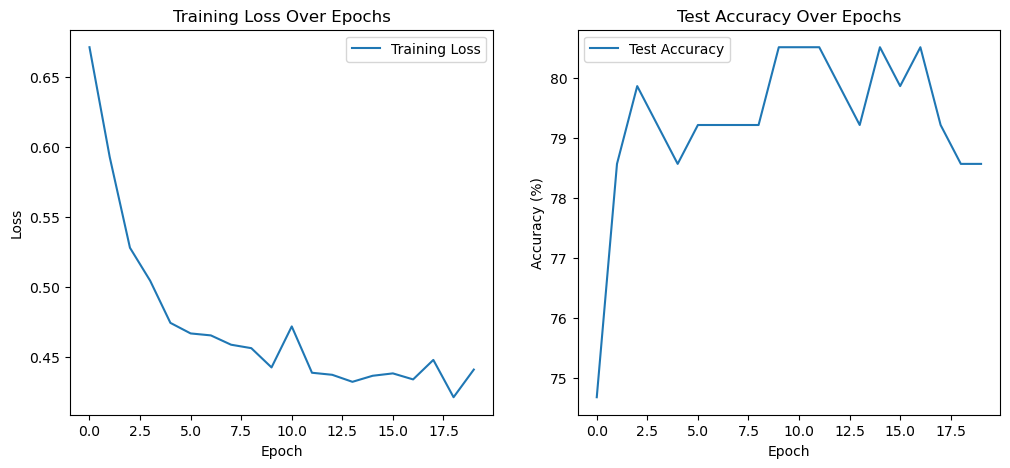

In [189]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

In [190]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [191]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [192]:
data_array = np.hstack((X, y.reshape(-1, 1)))

In [193]:
data_array.shape

(768, 9)

In [194]:
# Split sequences function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Apply sequence transformation
n_steps = 5
X, y = split_sequences(data_array, n_steps)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [195]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((611, 5, 8), (611,), (153, 5, 8), (153,))

In [196]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1) # Conv1d는 (batch_size, channels, sequence_length) 형태가 필요해
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1) # (batch, steps, features) → (batch, features, steps)로 변경
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [197]:
# Define the 1D CNN model
class DiabetesCNN(nn.Module):
    def __init__(self):
        super(DiabetesCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # 특성 개수를 8으로 맞춤
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 5, 64)  # Adjust the linear layer input size accordingly
        self.fc2 = nn.Linear(64, 1)  # 이진 분류이므로 출력 뉴런 1개로 변경
        self.sigmoid = nn.Sigmoid()  # 마지막에 sigmoid 적용
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

In [198]:
# Initialize the model, loss function, and optimizer
model = DiabetesCNN()

In [201]:
# Print the summary of the model
summary(model, input_size=(8, 5), batch_size=1) # (batch_size=1, channels=8, sequence_length=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                 [1, 16, 5]             400
            Conv1d-2                 [1, 32, 5]           1,568
            Linear-3                    [1, 64]          10,304
            Linear-4                     [1, 1]              65
           Sigmoid-5                     [1, 1]               0
Total params: 12,337
Trainable params: 12,337
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
